<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/ABC_Flow/ABC_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Advection and diffusion by the ABC flow**

This notebook applies the forward Kolmogorov equation derived in *Craske J. et al. 2024* to the case of a scalar concentration evolving subject to an advection diffusion equation in a triply peridioc domain. The advection diffusion equation is solved using a Fourier psuedo-spectral method, while the relevant terms in the forward Kolmogorov equation are estimated using histograms.

First let's import everything we need to run the rest of the notebook.

In [48]:
from   scipy import sparse
import numpy as np
import h5py, copy
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

**Problem setup**

We solve the equation for the scalar concentration
\begin{equation}
\partial_t Y + \left( \boldsymbol{U} \cdot \nabla \right) Y = \alpha \Delta Y,
\end{equation}
over the time interval $t \in [0,1]$ in a triply-periodic box $\Pi^3$, with the velocity field given by the so called ABC flow
\begin{equation}
 \boldsymbol{U} = 
 \begin{pmatrix} 
 A \sin(X_3) + C \cos(X_2) \\
 B \sin(X_1) + A \cos(X_3) \\  
 C \sin(X_2) + B \cos(X_1) 
 \end{pmatrix}.
\end{equation}
As an initial condition we prescribe an interface,
\begin{equation}
Y_{t=0} = \tanh(10\boldsymbol{X}).
\end{equation}

Below we setup some helper functions used to implement our solver for these equations:

In [2]:
def wavenumbers(N):
    """Return wavenumbers for the periodic domain."""
    ik = 1j*np.zeros(N)
    ik[0:N//2+1] = 1j*np.arange(0,N//2+1)
    ik[N//2+1:]  = 1j*np.arange(-N//2+1,0,1)
    return ik

def domain(N,test=False):
    """Generate a grid for x."""
    if test == True:
        h = 2*np.pi/N
        x = h*np.arange(1,N+1,1)
    else:
        x, h = np.linspace(-np.pi,np.pi,N,retstep=True)
    return x,h

def derivative(f,axis=0,deriv=1):
    """Compute any 1st or 2nd derivative of a 1,2 or 3D field."""

    # Determine the dimension (dim) and size (N).
    dim = len(f.shape)
    N   = f.shape[0]

    # Create the 1st and 2nd derivative operators
    ik = wavenumbers(N)
    if deriv == 1:
        ik[N//2] = 0
        D = sparse.diags([ik],[0])   
    elif deriv == 2:
        D = sparse.diags([ik**2],[0])
    else:
        return f
      
    I = sparse.eye(N)
    F = f.flatten()

    # Compute the derivative
    if dim == 1:
        return D@F
    
    elif dim == 2:

        if axis == 0:
            Di = sparse.kron(D,I)
        elif axis == 1:    
            Di = sparse.kron(I,D)
        
        df = Di@F 
        return df.reshape((N,N))
    
    elif dim == 3:

        if axis == 0:
            Di = sparse.kron(sparse.kron(D,I),I)
        elif axis == 1:    
            Di = sparse.kron(sparse.kron(I,D),I)
        elif axis == 2:    
            Di = sparse.kron(sparse.kron(I,I),D)

        df = Di@F 
        return df.reshape((N,N,N))
    
    return None

We then write the solver for the advection diffusion equation using a Fourier pseudo-spectral method. In addition to the numerical resolution in space $N_x$ and time $\Delta t$, the parameters $A,B,C$ and $\alpha$ (here equivalent to the Peclet number) are left free for the user to change so that they can examine their influence on the pdf.

In [102]:
# Parameters
𝛼 = 1/10
A = 1
B = 1
C = 1

def solve(T,Nx=64,Δt=5e-03):
    """Solve the advection diffusion equation with an ABC flow."""

    # Domain
    x, h = domain(Nx)
    t = np.arange(0,T,Δt)
    Nt = len(t)
    
    # Derivatives
    ik = wavenumbers(Nx)
    II = sparse.eye(Nx)
    D2 = sparse.diags([ik**2],[0])
    L = sparse.kron(sparse.kron(D2,II),II) + sparse.kron(sparse.kron(II,D2),II) + sparse.kron(sparse.kron(II,II),D2)
    L*= 𝛼
    III = sparse.eye(Nx**3,format="csr")
    LHS = sparse.csr_matrix(III/Δt - L/2)
    RHS = sparse.csr_matrix(III/Δt + L/2)

    ik[Nx//2] = 0
    D = sparse.diags([ik],[0])  
    D_0 = sparse.kron(sparse.kron(D,II),II) 
    D_1 = sparse.kron(sparse.kron(II,D),II)
    D_2 = sparse.kron(sparse.kron(II,II),D)    
    Grad = [D_0,D_1,D_2]

    # ABC flow
    I   = np.ones(Nx) 
    X_1 = np.kron(np.kron(x,I),I).reshape((Nx,Nx,Nx))
    X_2 = np.kron(np.kron(I,x),I).reshape((Nx,Nx,Nx))
    X_3 = np.kron(np.kron(I,I),x).reshape((Nx,Nx,Nx))

    U_1 = A*np.sin(X_3) + C*np.cos(X_2)
    U_2 = B*np.sin(X_1) + A*np.cos(X_3)
    U_3 = C*np.sin(X_2) + B*np.cos(X_1)
    U   = [U_1,U_2,U_3]

    # check divergence = 0
    div_U = 0*U_1
    for i,U_i in enumerate(U):
        U_i_hat = np.fft.fftn(U_i,axes=(i,)) 
        dU_i_hat = derivative(U_i_hat,axis=i)
        dU_i = np.fft.ifftn(dU_i_hat,axes=(i,)).real
        div_U += dU_i
    assert abs( np.sum(div_U) * h**3 ) < 1e-15
    
    # Initial conditions
    Y_data   = []
    DY2_data = []

    Y_0 = np.tanh(10*(X_1 + X_2 + X_3))
    Y_hat = np.fft.fftn(Y_0).flatten()
    
    # Solve
    for n,t_i in enumerate(t):

        # Save snapshots
        if n >= len(t)-3:
            DY2 = 0*U_1
            for i,U_i in enumerate(U):
                DY_hat_i = Grad[i]@Y_hat
                DY_i = np.fft.ifftn(DY_hat_i.reshape((Nx,Nx,Nx))).real
                DY2 += DY_i**2
            DY2_data.append(DY2)
            Y_data.append(np.fft.ifftn(Y_hat.reshape((Nx,Nx,Nx))).real)

        # Compute NL terms        
        u_grad_Y = np.zeros((Nx,Nx,Nx))
        for i,U_i in enumerate(U):
            DY_hat_i  = Grad[i]@Y_hat
            DY_i      = np.fft.ifftn(DY_hat_i.reshape((Nx,Nx,Nx))).real
            u_grad_Y += U_i*DY_i
        F_hat = np.fft.fftn(u_grad_Y).flatten()

        # Update
        Y_hat = sparse.linalg.spsolve(LHS,RHS.dot(Y_hat) - F_hat)

    # Save data
    f = h5py.File('snapshots.h5', mode='w')
    tasks = f.create_group("tasks")
    tasks['t'] = t
    tasks['x'] = x
    tasks['Y'] = Y_data
    tasks['DY2'] = DY2_data
    f.close()

    return None

After defining the solver we then integrate the equations forwards 1 time-unit to generate some-snapshots.

In [103]:
# Time-integrate 
solve(T=1,Nx=64)

The forward Kolmogorov equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f_Y = \frac{\partial^2 }{ \partial y^2} \left( \mathbf{D}^{(2)} f_Y \right), \quad \text{where} \quad \mathbf{D}^{(2)} = -\mathbb{E}_{Y_t}[\alpha|\nabla Y_t|^2],
\end{equation}
and $f_Y(y;t)$ is the global probability density function. This density describes the probability of finding a scalar concentration $y$ at a time $t$ in the triply periodic domain $\Pi^3$. Having time integrated the transport equation for the solute concentration we have a set of snapshots $Y_t$ at discrete time intervals $t_n$. Loading the snapshots below we now use this data to calculate the terms in this equation.

In [104]:
# Data loading
file   = h5py.File('snapshots.h5', mode='r')
times  = file['tasks/t'][:]
X1_data = file['tasks/x'][:]
X2_data = file['tasks/x'][:]
X3_data = file['tasks/x'][:]

Y_data   = file['tasks/Y'][:,...]
dY2_data = file['tasks/DY2'][:,...]

file.close()

To evaluate the left hand side we estimate the pdf $f_Y(y;t)$ (using a histogram) and then compute its time derivative $\partial_t f$ using central differences.

In [105]:
N_bins = 128

# PDF f_Y
f_np1,y = np.histogram(Y_data[-1,...].flatten(),bins=N_bins,density=True); # n + 1 
f_nm1,y = np.histogram(Y_data[-3,...].flatten(),bins=N_bins,density=True); # n - 1 
y       = 0.5*(y[1:] + y[:-1]); dy = y[1] - y[0];

# Time derivate df_Y/dt
dt   = times[-1] - times[-2]
dfdt = (1./2.)*f_np1 - (1./2.)*f_nm1
dfdt /=dt

To calculate the right hand side we compute the coefficient
\begin{equation}
\mathbb{D}^{(2)} \equiv -\alpha \mathbb{E}_{Y_t}[|\nabla Y_t|^2] = - \alpha  \int \frac{\phi f_{\Phi,Y}(\phi, y; t)}{f_Y(y;t)} d \phi, \quad \text{where} \quad \Phi = |\nabla Y_t|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram. Subsequently we create the derivative operator $L = \partial^2_y$ using central differences.

In [106]:
# Expectation
f_YΦ,y,φ = np.histogram2d(Y_data[-2,...].flatten(), dY2_data[-2,...].flatten(),bins=N_bins,density=True) # n
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
y = 0.5*(y[1:] + y[:-1]); dy = y[1] - y[0];

f_Y =  np.sum(  f_YΦ,axis=1)*dφ     # f_Y(y)
E   = (np.sum(φ*f_YΦ,axis=1)*dφ)/f_Y; # E{Φ|Y} = int_φ f_Φ|Y(φ|y)*φ dφ
D2  = -𝛼*E

# Derivative
N = len(y)
L = np.zeros((N,N))
for i in range(N):
  L[i,i] = -2.
  if i < N-1:
    L[i,i+1] = 1
  if i > 0:
    L[i,i-1] = 1
L   *= 1./(dy**2);

Having computed the terms appearing in the left and right hand sides of the forward Kolmogorov for this advection diffusion problem we now investigate their form as well as validating that the left and right hand sides are equal. The figure below plots (a) the scalar field $Y(\boldsymbol{X},t_n)$, (b) the density and the diffusion coefficient $f_Y, \mathbf{D}^{(2)}$ and (c) the right and left hand sides of the forward Kolmogorov equation. To avoid artificially smoothing the data in frame (c) we twice integrate the forward Kolmogorov equation with respect to $s$ when comparing the left and right hand side.

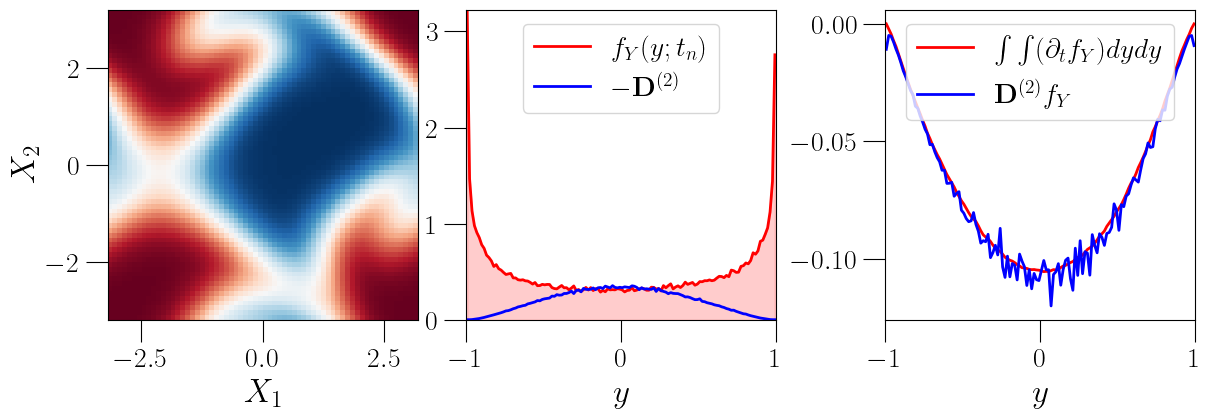

In [107]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 16
mpl.rcParams['ytick.major.size'] = 16

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=(12,6),layout='constrained')

axs[0].pcolormesh(X1_data,X2_data,Y_data[-1,:,:,0],cmap='RdBu',norm='linear')
axs[0].set_ylabel(r'$X_2$',fontsize=24)
axs[0].set_xlabel(r'$X_1$',fontsize=24)

axs[1].plot(y,f_Y,'r', linewidth=2,label=r'$f_Y(y;t_n)$')
axs[1].fill_between(x=y,y1=f_Y,color= "r",alpha= 0.2)
axs[1].plot(y,-D2 ,'b', linewidth=2,label=r'$-\mathbf{D}^{(2)}$')

axs[1].set_xlabel(r'$y$',fontsize=24)
axs[1].set_xlim([-1,1])
y1 = np.max(-D2)
y2 = np.max(f_Y)
axs[1].set_ylim([0.,max(y1,y2)])
axs[1].legend(loc=9,fontsize=20)

LHS = np.linalg.solve(L,dfdt)
RHS = D2*f_Y
axs[2].plot(y,LHS,'r', linewidth=2,label=r'$ \int \int (\partial_t f_Y) dydy$')
axs[2].plot(y,RHS,'b', linewidth=2,label=r'$\mathbf{D}^{(2)} f_Y$')
axs[2].set_xlabel(r'$y$',fontsize=24)
axs[2].set_xlim([-1,1])
axs[2].legend(loc=9,fontsize=20)

for n,ax in enumerate(axs):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_box_aspect(aspect=1)

plt.show()

We can then use the code outlined to develop two routines 'Data' and 'Plot' to compute and plot the time-evolution of the scalar field and the pdf and different time istants

In [108]:
def Data(N_bins=128):
    """"Compute the histogram from DNS data."""

    # Data loading
    file   = h5py.File('snapshots.h5', mode='r')
    times  = file['tasks/t'][:]
    X1_data = file['tasks/x'][:]
    X2_data = file['tasks/x'][:]
    X3_data = file['tasks/x'][:]

    Y_data   = file['tasks/Y'][:,...]
    dY2_data = file['tasks/DY2'][:,...]

    file.close()

    # PDF f_Y
    f_np1,y = np.histogram(Y_data[-1,...].flatten(),bins=N_bins,density=True); # n + 1 
    f_nm1,y = np.histogram(Y_data[-3,...].flatten(),bins=N_bins,density=True); # n - 1 
    y       = 0.5*(y[1:] + y[:-1]); dy = y[1] - y[0];

    # Time derivate df_Y/dt
    dt   = times[-1] - times[-2]
    dfdt = (1./2.)*f_np1 - (1./2.)*f_nm1
    dfdt /=dt

    # Expectation
    f_YΦ,y,φ = np.histogram2d(Y_data[-2,...].flatten(), dY2_data[-2,...].flatten(),bins=N_bins,density=True) # n (-3)
    φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
    y = 0.5*(y[1:] + y[:-1]); dy = y[1] - y[0];

    f_Y =  np.sum(  f_YΦ,axis=1)*dφ     # f_Y(y)
    E   = (np.sum(φ*f_YΦ,axis=1)*dφ)/f_Y; # E{Φ|Y} = int_φ f_Φ|Y(φ|y)*φ dφ
    
    return X1_data,X2_data,Y_data,y,f_Y,E


def Plot(x_data,y_data,Y_data,y,f,E,stop_sim_time):
    """Plot snapshots of the histogram and Y(X)."""
    
    fig, axs = plt.subplots(2,1,figsize=(4,8),layout='constrained')

    axs[0].pcolormesh(x_data,y_data,Y_data[-1,:,:,0],cmap='RdBu',norm='linear')
    axs[0].set_ylabel(r'$X_2$',fontsize=24)
    axs[0].set_xlabel(r'$X_1$',fontsize=24)
    axs[0].set_xticks([-2,0,2])
    axs[0].set_yticks([-2,0,2])

    axs[1].plot(y,f,'r', linewidth=2)
    axs[1].fill_between(x=y,y1=f,color= "r",alpha= 0.2)
    axs[1].plot(y,E,'b', linewidth=2)
    
    axs[1].set_xlim([-1.05,1.05])
    # lim = max(np.max(E),np.max(f))
    # axs[1].set_ylim([0.,1.1*lim])
    axs[1].set_xlabel(r'$y$'  ,fontsize=24)

    for n,ax in enumerate(fig.axes):
        ax.set_box_aspect(aspect=1)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

    plt.show()
    plt.savefig('ABC_Flow_t%2.2f.png'%stop_sim_time,dpi=200)

    return None;

Choosing four time-instants we then plot the time-evolution of the pdf (red), the diffusion coefficient (blue) and the scalar field. Choosing a larger spatial resolution will reduce the noise in the plots but at the expense of taking longer to run.

time t=0.500 



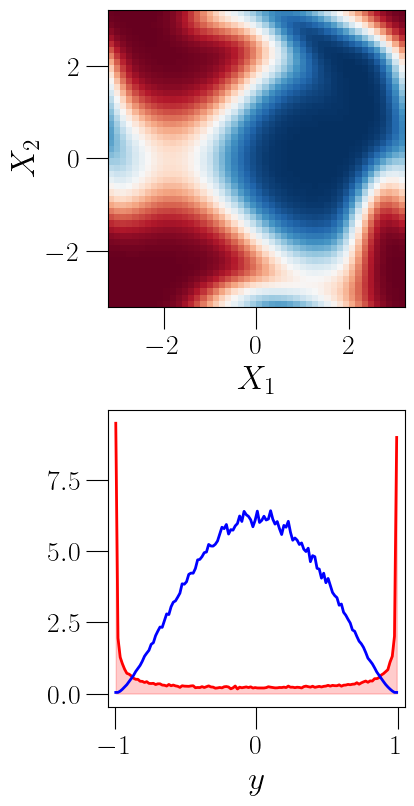

time t=1.000 



<Figure size 640x480 with 0 Axes>

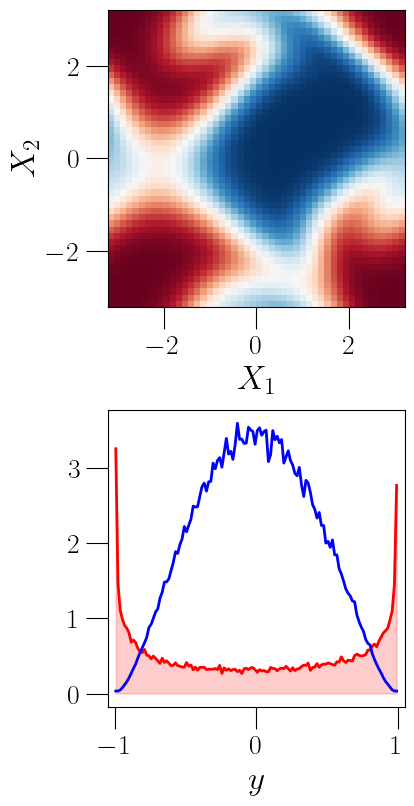

time t=2.000 



<Figure size 640x480 with 0 Axes>

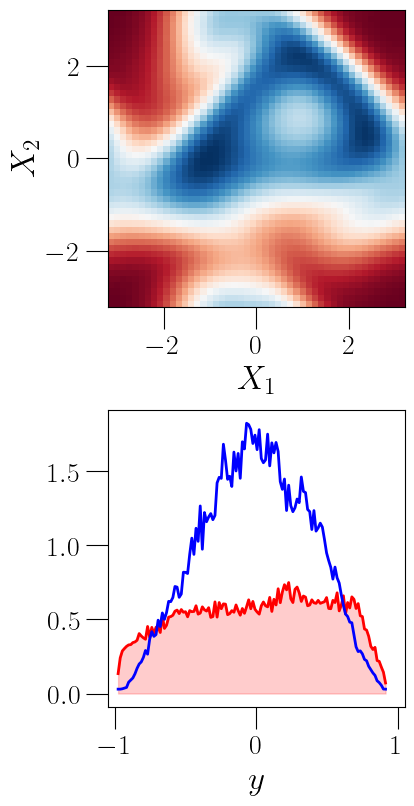

time t=4.000 



<Figure size 640x480 with 0 Axes>

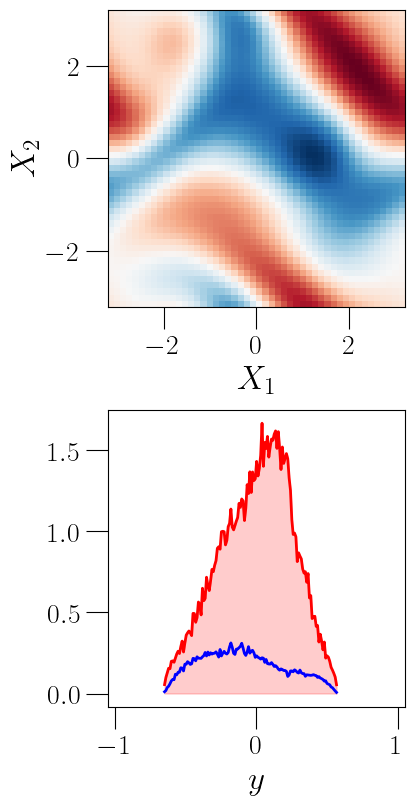

<Figure size 640x480 with 0 Axes>

In [109]:
for t in [0.5,1,2,4]:
    print('time t=%3.3f \n'%t)
    solve(T=t,Nx=48,Δt=5e-03)
    x_data,y_data,Y_data,y,f,E = Data(N_bins=128)
    Plot(x_data,y_data,Y_data,y,f,E,stop_sim_time=t)